## Chapter 10: Sequence Hacking, Hashing, and Slicing

In [ ]:
from array import array
import reprlib
import numbers
import math
import functools
import operator

class Vector:
    typecode = 'd'
    shortcut_names = 'xyzt'    
    
    def __init__(self, components) -> None:
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self) -> str:
        # This lib gives us a limited-length representation of the array
        components = reprlib.repr(self._components)
        components = components[components.find('['):-1]
        return 'Vector({})'.format(components)
    
    def __str__(self) -> str:
        return str(tuple(self))
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self):
        return bool(abs(self))
    
    # With the next two functions defined, objs of this class will be iterators
    def __len__(self):
        return len(self._components)
    
    # Now, when we grab a slice from a vector, we will get a similar vector, with just the sliced values.
    def __getitem__(self, index):
        cls = type(self)
        
        # If the index is actually a slice, then return a vector of equivalent type containing the sliced values.
        if isinstance(index, slice):
            return cls(self._components[index])
        # If it's just an int, return the value at that index
        elif isinstance(index, numbers.Integral):
            return self._components[index]
        else:
            msg = f"{cls.__name__} indices must be integers"
            raise TypeError(msg)
        
    # When extracting an obj attribute, the compiler first searches to see if any exist. If not, it calls
    # the following dunder method. Now, we use any of the "short-cut" names to determine a given value.
    # Eg with "v = Vector([1, 2, 3])", saying "v.y" corresponds to 2 because of the following declaration
    def __getattr__(self, name: str):
        cls = type(self)
        if len(name) == 1:
            pos = cls.shortcut_names.find(name)
            if 0 <= pos < len(self._components):
                return self._components[pos]
            
        msg = f"{cls.__name__} has no attribute {name}"
        raise AttributeError(msg)
    
    # __getattr__ is read only. We must also construct a __setattr__ if we'd like to set values or control how the read-only parameters are read.
    # The function above has a problem that if someone says "v.x = 4", this will create a new parameter called x within v. Therefore, we must throw
    # an error upon setting any of the shortcut names.
    def __setattr__(self, name: str, value) -> None:
        cls = type(self)
        if len(name) == 1:
            if name in cls.shortcut_names:
                error = f'read-only attribute {name}'
            elif name.islower():
                error = f"can't set attributes 'a' to 'z' in {cls.__name__}"
            else:
                error = ""
            
            if error:
                raise AttributeError(error)
            
        super().__setattr__(name, value)
        
    def __eq__(self, o: object) -> bool:
        # return tuple(self) == tuple(o)  ->  This is highly inefficient for large vectors since we are building a new tuple from scratch and
        #                                     must be build by copy. Also, any data struct that happens to have the same numbers
        #                                     will still come out equal. Therefore, we do the following instead...
        
        if (type(self) != type(o)) or (len(self) != len(o)):
            return False
        
        # The following is great and pythonic but still not ideal cause for loops in python are slow.
        # for a, b in zip(self, o):
        #     if a != b:
        #         return False
        # return True
        
        return all(a == b for a, b in zip(self, o)) # Best solution!
        
    def __hash__(self) -> int:
        # hashes = (hash(x) for x in self._components)  ->  Also works but preferred method is below
        hashes = map(hash, self._components)
        
        # The reduce func uses an operator to aggregate an iterator into a single value. The "0" is the initial value
        return functools.reduce(operator.xor, hashes, 0)

In [3]:
from itertools import chain # Basically flattens iterables then horizontally concatenates them 
list(chain('hello', ' ', 'friend'))

['h', 'e', 'l', 'l', 'o', ' ', 'f', 'r', 'i', 'e', 'n', 'd']

## Chapter 11: Interfaces: From Protocols to ABCs

In [8]:
# Rather than creating our own ABCs (Abstract base classes), when possible use already built interfaces
import collections
import reprlib
from random import shuffle

Card = collections.namedtuple("Card", ['rank', 'suit'])

# All dunder methods (except __repr__) and insert are required by the ABC "collections.MutableSequence." This is much better than
# creating our own.
class FrenchDeck(collections.MutableSequence):
    ranks = [str(n) for n in range(2,11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()
    
    def __init__(self) -> None:
        self._cards = [Card(rank, suit) for suit in self.suits for rank in self.ranks]
        
    def __len__(self) -> int:
        return len(self._cards)
    
    def __getitem__(self, position: int) -> Card:
        return self._cards[position]
    
    # Allows setting using an index. Needed for shuffling
    def __setitem__(self, position: int, value: Card) -> None:
        self._cards[position] = value
        
    # Deletes an item from the class
    def __delitem__(self, position):
        del self._cards[position]
        
    def __repr__(self) -> str:
        cards = reprlib.repr(self._cards)
        return 'FrenchDeck({})'.format(cards)
        
    def insert(self, position: int, value: Card) -> None:
        self._cards.insert(position, value)
        
deck = FrenchDeck()
print(deck)

# The "random.shuffle" function uses "duck typing." This means it automatically assumes that the variable passed in has the "__setitem__" dunder method.
# It doesn't care what type of obj it is as long as it has that method. This is often a more-pythonic interaction than requiring our class to inherit
# from some other ABC. Of course, we do use an ABC here but that is to ensure we have everything we need to create a mutable sequence. If needed we could
# have use the shuffle function without creating a sequence by just adding a single dunder method (though I don't know when that would be used). 
shuffle(deck)
print(deck)

FrenchDeck([Card(rank='2', suit='spades'), Card(rank='3', suit='spades'), Card(rank='4', suit='spades'), Card(rank='5', suit='spades'), Card(rank='6', suit='spades'), Card(rank='7', suit='spades'), ...])
FrenchDeck([Card(rank='10', suit='clubs'), Card(rank='8', suit='hearts'), Card(rank='J', suit='hearts'), Card(rank='4', suit='spades'), Card(rank='10', suit='spades'), Card(rank='6', suit='clubs'), ...])


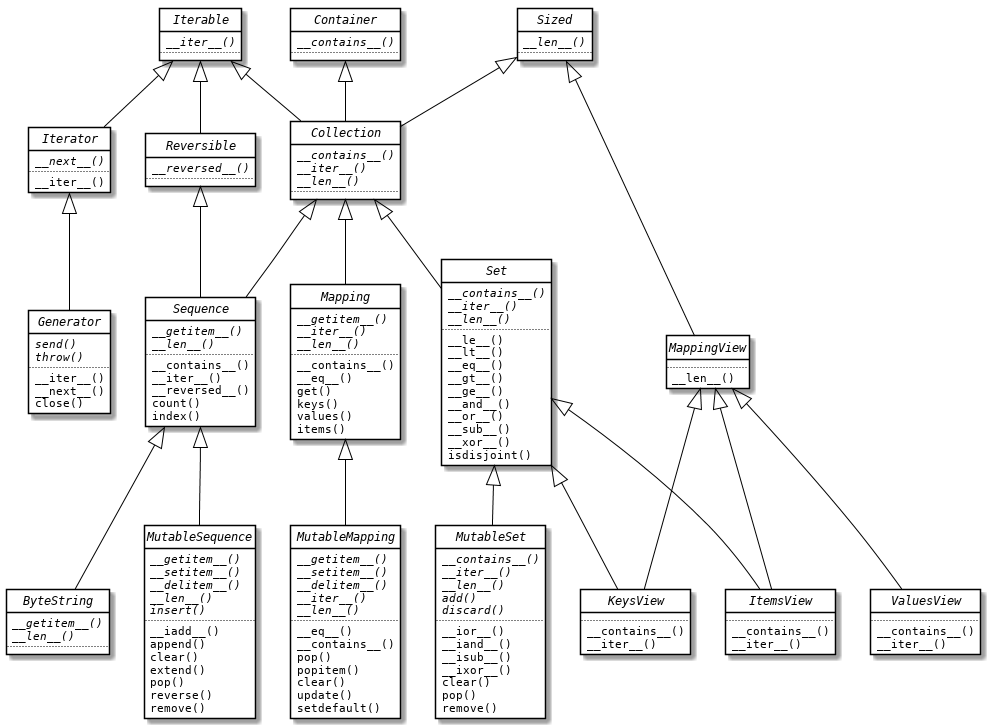

In [9]:
from IPython.display import Image

# This image displays the ABC's within collection.abc with each mapping
Image("./uml_ABCs.png")

In [10]:
# Demonstrating a user-generated ABC
import abc

# Abstract classes must inherit from abc.ABC
class Tombola(abc.ABC):
    # This decorator makes the following function an abstract function. Derived classes MUST define any abstract function or
    # it will throw an exception upon generating an instance of the class.
    @abc.abstractclassmethod
    def load(self, iterable):
        """Add items from an iterable"""
        
    @abc.abstractclassmethod
    def pick(self):
        """Remove item at random, returning it. THis method should raise 'LookupError' when instance is empty"""
        
    def loaded(self):
        return bool(self.inspect())
    
    # Definitely not the best way to handle this function. This example just shows that we can use abstract methods within 
    # concrete methods and it will use the appropriate implementation
    def inspect(self):
        items = []
        while True:
            try:
                items.append(self.pick())
            except LookupError:
                break
        
        self.load(items)
        return tuple(sorted(items))

In [13]:
# False implementation to show ABC at work
class Fake(Tombola):
    def pick():
        return 13
    
fake = Fake()

TypeError: Can't instantiate abstract class Fake with abstract methods load

In [28]:
# Implementation of the Tombola
import random

class BingoCage(Tombola):
    def __init__(self, items):
        self._randomizer = random.SystemRandom()
        self._items = []
        self.load(items)
        
    def load(self, items):
        # list.extend() takes a list and appends each element seperate to the list. list.append() will add an entire list into the next element
        self._items.extend(items)
        self._randomizer.shuffle(self._items)
        
    def pick(self):
        try:
            return self._items.pop()
        except IndexError:
            raise LookupError('pick from empty BingoCage')
        
    # Now we don't need to explicitly "pick"
    def __call__(self):
        return self.pick()
        
bingo = BingoCage([5,3,9,8])
print(bingo(), bingo(), bingo(), bingo())

bingo2 = BingoCage([5,3,9,8])
print(bingo2(), bingo2(), bingo2(), bingo2())
try:
    bingo2()
except LookupError as e:
    print(e)

9 5 3 8
9 8 5 3
pick from empty BingoCage


In [30]:
# We do not need to use inheritance to make an "isinstance(x, y)" true. We can also use registration
from random import randrange

@Tombola.register
class TomboList(list):
    def pick(self):
        if self:
            position = randrange(len(self))
            return self.pop(position)
        else:
            raise LookupError("Pop from empty TomboList")
       
    # Creates load function that's identical to the list.extend method
    load = list.extend
    
    def loaded(self):
        return bool(self)
    
    def inspect(self):
        return tuple(sorted(self))
    
    def __call__(self):
        return self.pick()
    
tombols = TomboList([5,3,9,8])
print(tombols(), tombols(), tombols(), tombols())
print("TomboList is a Tombola:", isinstance(tombols, Tombola), "even if there's no inheritance!")

5 3 8 9
TomboList is a Tombola: True


## Chapter 12: Inheritance: For Good or For Worse
In short, use composition if possible. Try to stay away from multiple inheritance unless completely necessary.

## Chapter 13: Operator Overloading: Doing it Right

In [1]:
# This is the same class as chapter 10 notes (see above). But we're gonna implement a few new features.
from array import array
import reprlib
import numbers
import math
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    shortcut_names = 'xyzt'    
    
    def __init__(self, components) -> None:
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self) -> str:
        components = reprlib.repr(self._components)
        components = components[components.find('['):-1]
        return 'Vector({})'.format(components)
    
    def __str__(self) -> str:
        return str(tuple(self))
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self):
        return bool(abs(self))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index):
        cls = type(self)        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral):
            return self._components[index]
        else:
            msg = f"{cls.__name__} indices must be integers"
            raise TypeError(msg)
        
    def __getattr__(self, name: str):
        cls = type(self)
        if len(name) == 1:
            pos = cls.shortcut_names.find(name)
            if 0 <= pos < len(self._components):
                return self._components[pos]
            
        msg = f"{cls.__name__} has no attribute {name}"
        raise AttributeError(msg)

    def __setattr__(self, name: str, value) -> None:
        cls = type(self)
        if len(name) == 1:
            if name in cls.shortcut_names:
                error = f'read-only attribute {name}'
            elif name.islower():
                error = f"can't set attributes 'a' to 'z' in {cls.__name__}"
            else:
                error = ""
            
            if error:
                raise AttributeError(error)
            
        super().__setattr__(name, value)
        
    def __eq__(self, o: object) -> bool:      
        if (type(self) != type(o)) or (len(self) != len(o)):
            return False        
        return all(a == b for a, b in zip(self, o))
    # We don't really need to define __ne__ (not equal) in python 3 because it defaults to "not __eq__"
        
    def __hash__(self) -> int:
        hashes = map(hash, self._components)
        return functools.reduce(operator.xor, hashes, 0)
    
    # New chapter 13 dundermethods. Operator Overloading
    
    # Works with all iterables!
    def __add__(self, other):
        try:
            # Creates iterable of tuples containing all from self, other. If one is smaller than the other, it is padded with 0
            pairs = itertools.zip_longest(self, other, fillvalue=0.0)
            return Vector(a + b for a, b in pairs)
        
        # This try-except block ensures that an input value has the correct type (i.e. an iterable). If not, it returns a NotImplemented var
        # thus telling the compiler to try b.__radd__(a)
        except TypeError:
            return NotImplemented
    
    # The operator overload above only works for a + b (where a is a Vector obj and b is some other iterable). To make it work both ways, we need to
    # add this "reverse" add function that returns a + b from a use of b + a. Just fyi, python uses an implementation order when it sees any a + b.
    # First, it tries to find an a.__add__(b) method. If none exists, only then does it try to find b.__radd__(a).
    def __radd__(self, other):
        return self + other
    
    # Theoretically we'd want mul to work for both scalars and other vectors. However, libs such as numpy ignore this so we will as well
    def __mul__(self, scalar):
        if isinstance(scalar, numbers.Real):
            return Vector(n * scalar for n in self)
        else:
            return NotImplemented 
    
    def __rmul__(self, scalar):
        return self * scalar
    
    def __matmul__(self, other):
        try:
            return sum(a * b for a, b in zip(self, other))
        except TypeError:
            return NotImplemented
        
    def __rmatmul__(self, other):
        return self @ other